# IML Ass3 Code Implementation

# The effect of unlabelled data on Titter sentiment classification

###                                                                        student name: Zixi Zhao        student id: 1306664

# Import Module

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from array import array
from sklearn.cluster import KMeans

# Load data from pickle file

In [2]:
train_emb = pd.read_pickle(r'./sentence-transformers/train_emb.pkl') #1
test_emb = pd.read_pickle(r'./sentence-transformers/test_emb.pkl') #4
development_emb = pd.read_pickle(r'./sentence-transformers/dev_emb.pkl') #7
unlabeled_emb = pd.read_pickle(r'./sentence-transformers/unlabeled_emb.pkl') #10

# Processing data

In [3]:
#1 train set + sentence-transformers
train_emb_sentiment = train_emb.loc[:,"Sentiment"]
train_emb_demographic = train_emb.loc[:,"Demographic"]
train_emb = pd.DataFrame(train_emb.TFIDF.tolist())
train_emb["Sentiment"] = train_emb_sentiment
train_emb["Demographic"] = train_emb_demographic
#4 test set + sentence-transformers
test_emb_sentiment = test_emb.loc[:,"Sentiment"]
test_emb_demographic = test_emb.loc[:,"Demographic"]
test_emb = pd.DataFrame(test_emb.TFIDF.tolist())
test_emb["Sentiment"] = test_emb_sentiment
test_emb["Demographic"] = test_emb_demographic
#7 development set + sentence-transformers
development_emb_sentiment = development_emb.loc[:,"Sentiment"]
development_emb_demographic = development_emb.loc[:,"Demographic"]
development_emb = pd.DataFrame(development_emb.TFIDF.tolist())
development_emb["Sentiment"] = development_emb_sentiment
development_emb["Demographic"] = development_emb_demographic
#10 unlabeled data + sentence-transformers
unlabeled_emb = pd.DataFrame(unlabeled_emb.TFIDF.tolist())

# data description

In [4]:
train_emb.describe()

0             1             2             3             4    \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean      -0.069854     -0.116790      0.106678     -0.063920     -0.030915   
std        0.322511      0.332202      0.283023      0.288465      0.307195   
min       -1.472747     -1.850692     -1.101215     -1.295807     -1.352498   
25%       -0.297025     -0.345940     -0.086856     -0.245262     -0.230047   
50%       -0.079520     -0.133342      0.097193     -0.080713     -0.033851   
75%        0.151689      0.094338      0.289346      0.105922      0.161870   
max        1.490336      1.415218      1.376302      1.496027      1.526053   

                5             6             7             8             9    \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean      -0.209928      0.460349      0.068420      0.092670     -0.053699   
std        0.295974      0.391573      0.253726      0.260284      0.227060   
min       -1.367329     -1.333895     -1.164786     -1.107028     -1.091327   
25%       -0.414655      0.209343     -0.096862     -0.074725     -0.193489   
50%       -0.222768      0.484175      0.065816      0.101473     -0.046592   
75%       -0.020549      0.734385      0.230321      0.266443      0.092810   
max        1.187603      1.892549      1.212535      1.157038      1.327399   

       ...           374           375           376           377  \
count  ...  40000.000000  40000.000000  40000.000000  40000.000000   
mean   ...      0.099263     -0.279672      0.081209      0.166517   
std    ...      0.273282      0.308951      0.248258      0.258773   
min    ...     -1.269510     -1.549772     -1.158267     -1.023971   
25%    ...     -0.081337     -0.492331     -0.075899      0.001025   
50%    ...      0.094155     -0.297570      0.091651      0.155081   
75%    ...      0.278458     -0.086191      0.245855      0.327227   
max    ...      1.259690      1.231555      1.289253      1.540844   

                378           379           380           381           382  \
count  40000.000000  40000.000000  40000.000000  40000.000000  40000.000000   
mean      -0.160465      0.170150      0.284033     -0.110426     -0.016336   
std        0.296937      0.261129      0.366351      0.302067      0.346489   
min       -1.712098     -1.281583     -1.476120     -1.542259     -1.561761   
25%       -0.350541      0.001445      0.044038     -0.313654     -0.236345   
50%       -0.158666      0.165875      0.301840     -0.117450     -0.001306   
75%        0.029808      0.336997      0.538021      0.087747      0.213474   
max        1.426180      1.322212      1.764456      1.310833      1.923379   

                383  
count  40000.000000  
mean      -0.082419  
std        0.273723  
min       -1.396557  
25%       -0.255028  
50%       -0.075525  
75%        0.093206  
max        1.550157  

[8 rows x 384 columns]

In [5]:
train_emb.loc[:,"Sentiment"].value_counts()

negative    20000
positive    20000
Name: Sentiment, dtype: int64

<AxesSubplot:>

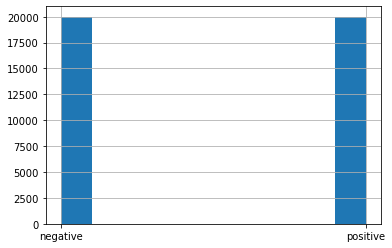

In [6]:
train_emb.loc[:,"Sentiment"].hist()

## Data wrangling

In [7]:
#the data that will be used in the following part
#training data
x_train = train_emb.iloc[:,:384].values
y_train = train_emb.iloc[:,384].values

#development data
x_predict = development_emb.iloc[:,:384].values
answer_y = development_emb.loc[:,"Sentiment"].values

#test data
x_test = test_emb.iloc[:,:384].values

## Base Line

In [8]:
#base line used in this case is use predict all value with same label
baseline = []
for i in range(4000):
    baseline.append("positive")
baseline_prediction = np.array(baseline)

In [9]:
#Print the classification report
print('classification',classification_report(answer_y,baseline_prediction))

classification               precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2000
    positive       0.50      1.00      0.67      2000

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000



C:\Users\95402\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\95402\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\95402\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression

### Logistic Regression training set

In [10]:
#do not need to run every time
#find the C value that give the best accuracy
c_list = []
first = 0.01
for i in range(100):
    c_list.append(first)
    first+=0.01
accuracy_list = []
for i in range(100):
    c = c_list[i]
    logreg = LogisticRegression(penalty = 'l1',solver = 'liblinear',C = c)
    logreg.fit(x_train,y_train)
    prediction = logreg.predict(x_predict)
    acc_score = accuracy_score(answer_y,prediction)
    accuracy_list.append(acc_score)
max_value = 0
index = -1
for i in range(len(accuracy_list)):
    if accuracy_list[i] > max_value:
        index = i
        max_value = accuracy_list[i]
#and at the end 

In [10]:
#Supervised learning Logistic Regression
logregmax = LogisticRegression(penalty = 'l1',solver = 'liblinear',C = 1.0000000000000007)
logregmax.fit(x_train,y_train)
prediction = logregmax.predict(x_predict)

print(classification_report(answer_y,prediction))
#the best accuracy is 0.69675

              precision    recall  f1-score   support

    negative       0.70      0.68      0.69      2000
    positive       0.69      0.71      0.70      2000

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000



In [11]:
#the accuracy of logistic regression using training data
accuracy_score(answer_y,prediction)

0.69675

In [12]:
#the f1 score of logistic regression using training data
f1_score(answer_y,prediction,pos_label = 'positive')

0.702038811102923

### Logistic Regression semi-supervised learning(unlabelled)

In [13]:
#Logistic Regression as the base of semi-supervised learning
base = LogisticRegression(penalty = 'l1',solver = 'liblinear',C = 1)

In [14]:
#this is the function that train the model, make the prediction
#and calculate the accuracy and f1 score
#which will be called by other code
def semi_logistic(result,result_answer,answer_y):
    self_training_model = SelfTrainingClassifier(base,threshold = 0.7)
    self_training_model.fit(result, result_answer)
    semi_result = self_training_model.predict(x_predict)
    accuracy = accuracy_score(answer_y,semi_result)
    f1score = f1_score(answer_y,semi_result,pos_label = 'positive')
    return accuracy,f1score

In [15]:
#this function is used as iteration, to loop and put different porportion of unlabelled data
#this function will keep calling function semi_logistic, and put the result in a list
def auto_semi():
    percentage = []
    per_accuracy = []
    per_acc_f1 = []
    for i in range(0,15):
        #train data
        j = i+1
        fraction = j*0.04
        unlabelrandom1 = unlabeled_emb.sample(frac=fraction,random_state = 1)
        x_rtrain = pd.DataFrame(x_train)
        frames = [x_rtrain,unlabelrandom1]
        result = pd.concat(frames).reset_index(drop = True)
        #answer
        answer = []
        myrange = 100000*j*0.04
        for i in range(int(myrange)):
            answer.append(-1)
        #train label
        y_rtrain = pd.DataFrame(y_train) 
        answer = pd.DataFrame(answer)
        frames_answer = [y_rtrain,answer]
        result_answer = pd.concat(frames_answer).reset_index(drop = True)
        accuracy_log,f1score_log = semi_logistic(result,result_answer,answer_y)
        percentage.append(myrange)
        per_accuracy.append(accuracy_log)
        per_acc_f1.append(f1score_log)
    return percentage,per_accuracy,per_acc_f1

In [16]:
#this function call the autosei function
#and we will get three list
percentage,per_accuracy,per_acc_f1 = auto_semi()

C:\Users\95402\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\95402\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\95402\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\95402\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

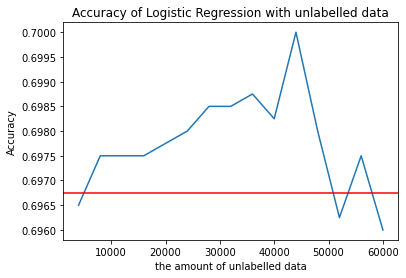

In [17]:
# plotting the points of accuracy
plt.plot(percentage,per_accuracy)
plt.axhline(y = 0.69675, color = 'r', linestyle = '-')
# naming the x axis 
plt.xlabel('the amount of unlabelled data') 
# naming the y axis 
plt.ylabel('Accuracy')     
# giving a title to my graph 
plt.title('Accuracy of Logistic Regression with unlabelled data')   
# function to show the plot 
plt.show() 

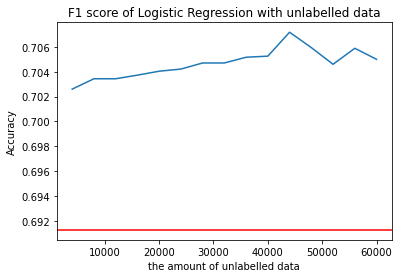

In [18]:
# plotting the points of accuracy
plt.plot(percentage,per_acc_f1)
plt.axhline(y = 0.6912700432680071, color = 'r', linestyle = '-')
# naming the x axis 
plt.xlabel('the amount of unlabelled data') 
# naming the y axis 
plt.ylabel('Accuracy')     
# giving a title to my graph 
plt.title('F1 score of Logistic Regression with unlabelled data')   
# function to show the plot 
plt.show() 

## K Means

### K Means training data

In [22]:
Kmeans = KMeans(n_clusters = 2,n_init = 10, random_state = 0).fit(x_train)
predict_value = Kmeans.predict(x_predict)
new_predict = []
for i in range(len(predict_value)):
    if int(predict_value[i]) == 0:
        new_predict.append('negative')
    elif int(predict_value[i]) ==1:
        new_predict.append('positive')
print("accuracy:")
accuracy_score(answer_y,new_predict)

accuracy:


0.57775

In [23]:
print("F1 score:")
f1_score(answer_y,new_predict,pos_label = 'negative')

F1 score:


0.6479049405878675

In [24]:
print(classification_report(answer_y,new_predict))

              precision    recall  f1-score   support

    negative       0.56      0.78      0.65      2000
    positive       0.63      0.38      0.47      2000

    accuracy                           0.58      4000
   macro avg       0.59      0.58      0.56      4000
weighted avg       0.59      0.58      0.56      4000



### K Means with unlabelled data

In [25]:
def kmeans_predict(fit_x_train,x_predict,answer_y):
    Kmeans = KMeans(n_clusters = 2,n_init = 10, random_state = 0).fit(fit_x_train)
    predict_value = Kmeans.predict(x_predict)
    new_predict = []
    for i in range(len(predict_value)):
        if int(predict_value[i]) == 0:
            new_predict.append('negative')
        elif int(predict_value[i]) ==1:
            new_predict.append('positive')
    acc = accuracy_score(answer_y,new_predict)
    f1 = f1_score(answer_y,new_predict,pos_label = 'negative')
    return acc,f1

In [26]:
x_rtrain = pd.DataFrame(x_train)
frames = [x_rtrain,unlabeled_emb]
result = pd.concat(frames).reset_index(drop = True)

In [27]:
def kmeans(result):
    k_percentage_s = []
    k_per_accuracy_s = []
    f1_kmeans = []
    for i in range(0,24):
        #train data
        j = i+1
        myrange = 5000*j
        result_f = result.sample(n=myrange,random_state = 1)
        accu,f1 = kmeans_predict(result_f,x_predict,answer_y)
        k_per_accuracy_s.append(accu)
        k_percentage_s.append(myrange)
        f1_kmeans.append(f1)
    return k_percentage_s,k_per_accuracy_s,f1_kmeans

In [28]:
k_percentage_s,k_per_accuracy_s,f1_per = kmeans(result)

In [29]:
keep = []
keep_acc = []
keep_f1 = []
f1_acc = []
for i in range(len(k_per_accuracy_s)):
    if k_per_accuracy_s[i] > 0.5:
        keep.append(k_percentage_s[i])
        keep_acc.append(k_per_accuracy_s[i])
for j in range(len(f1_per)):
    if f1_per[j] > 0.5:
        keep_f1.append(k_percentage_s[j])
        f1_acc.append(f1_per[j])

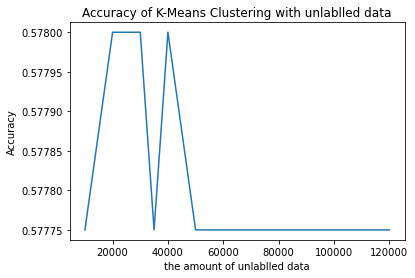

In [30]:
# plotting the points  
plt.plot(keep,keep_acc)     
# naming the x axis 
plt.xlabel('the amount of unlablled data') 
# naming the y axis 
plt.ylabel('Accuracy')     
# giving a title to my graph 
plt.title('Accuracy of K-Means Clustering with unlablled data')   
# function to show the plot 
plt.show() 

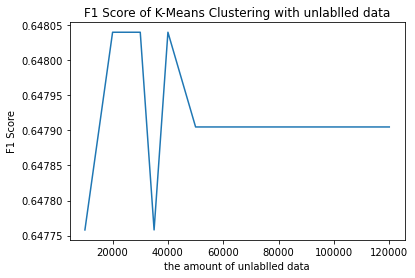

In [31]:
# plotting the points  
plt.plot(keep_f1,f1_acc)     
# naming the x axis 
plt.xlabel('the amount of unlablled data') 
# naming the y axis 
plt.ylabel('F1 Score')     
# giving a title to my graph 
plt.title('F1 Score of K-Means Clustering with unlablled data')   
# function to show the plot 
plt.show() 